In [1]:
import pymc as pm
import arviz as az
from linear_population import wtg_foundation
import numpy as np
import matplotlib.pyplot as plt
import graphviz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#### Testing different scour depths vs soil properties


#np.random.seed(0) # to keep it reproducible

# Size of dataset (number of turbines)
size = 10

# True parameter values
mu_soil_k = 1000000
var_soil_k = 100000

# mu_embedded_len = 45
# var_embedded_len = 2

# Nat frequency measurement noise
sigma = 0.0001

# Predictor variables
soil_k = np.random.normal(loc=mu_soil_k, scale=var_soil_k, size=size)

# embedded_len = np.random.normal(loc=mu_embedded_len, scale=var_embedded_len, size=size)
# all other FE model variables
#soil_k = [1000000, 1100000, 1200000, 1300000, 1400000]
# Simulate outcome variable 
Y = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k, embedded_len=40) + np.random.normal(loc=0, scale=sigma, size=size)
Y2 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k, embedded_len=42) + np.random.normal(loc=0, scale=sigma, size=size)
Y3 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k, embedded_len=44) + np.random.normal(loc=0, scale=sigma, size=size)
Y4 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k, embedded_len=46) + np.random.normal(loc=0, scale=sigma, size=size)
Y5 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k, embedded_len=48) + np.random.normal(loc=0, scale=sigma, size=size)

plt.scatter(soil_k, Y[1,:], label='40')
plt.scatter(soil_k, Y2[1,:], label='42')
plt.scatter(soil_k, Y3[1,:], label='44')
plt.scatter(soil_k, Y4[1,:], label='46')
plt.scatter(soil_k, Y5[1,:], label='48')
plt.xlabel('spring stiffness (N/m)')
plt.ylabel('1st nat freq (Hz)')
plt.title('Observed data (generated)')
plt.legend()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<AxesSubplot: title={'center': 'slope'}>

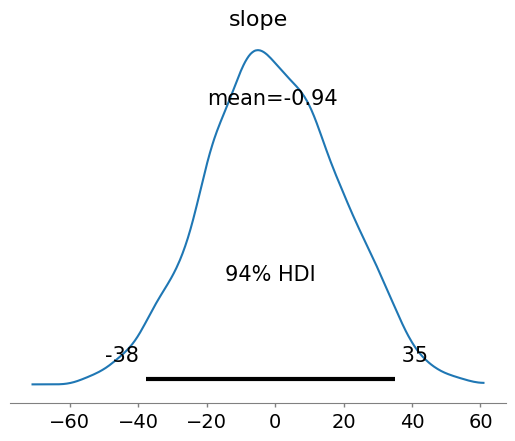

In [33]:
# Pooled model Example
with pm.Model() as pooled_model:
    slope = pm.Normal('slope', 1e+6, 1e+5)
    #intercept = pm.Normal('intercept', 0, 20)
    noise = pm.Exponential('noise', 0.1)
    
    #obs = pm.Normal('obs', slope*soil_k + intercept, noise, observed=Y)
    #w_n = pm.Normal('w_n', slope*soil_k, noise, observed=Y) # should this be calling the FE model? It would take forever to run...
    w_n = pm.Normal('w_n', wtg_foundation(soil_k_vec=soil_k), noise, observed=Y)
    
    pooled_trace = pm.sample(return_inferencedata=True)

az.plot_posterior(pooled_trace, var_names=['slope'])

array([[<AxesSubplot: title={'center': 'slope'}>,
        <AxesSubplot: title={'center': 'slope'}>],
       [<AxesSubplot: title={'center': 'noise'}>,
        <AxesSubplot: title={'center': 'noise'}>]], dtype=object)

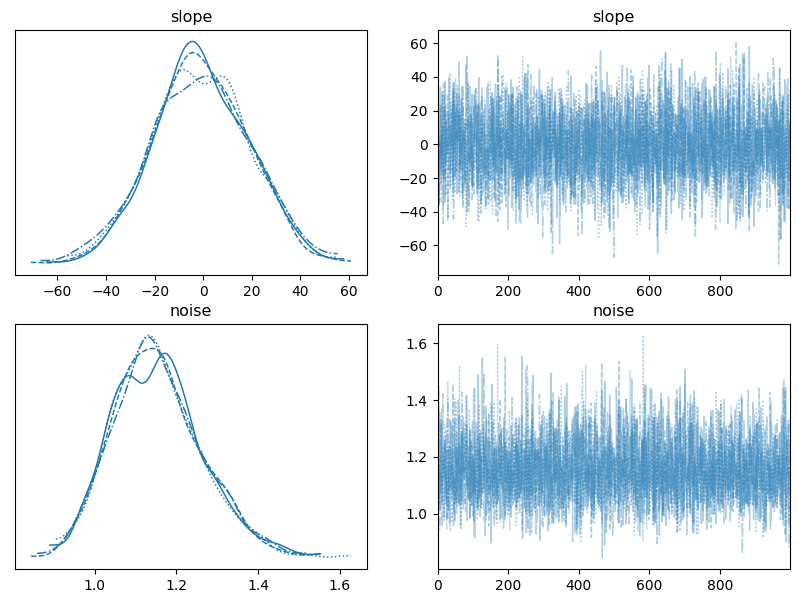

In [34]:
az.plot_trace(pooled_trace, figsize=(10,7))

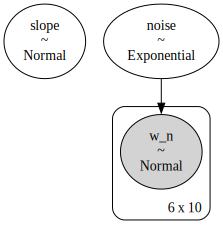

In [35]:
pm.model_to_graphviz(pooled_model)

In [5]:
# Testing lognormally generated data

np.random.seed(0) # to keep it reproducible

# Size of dataset (number of turbines)
size = 5 # turbines
n = 10 # observations

# v2

# global params
Ek = [0]
Vk = [0.05]
Vi = [0.01]
# draw local turbine means
Tk = np.random.lognormal(Ek, Vk, size=size)
# draw local turbine observations for each turbine
soil_k = np.zeros((n, size))
for i in range(size):
    soil_k[:,i] = np.random.lognormal(Tk[i] - 1, Vi, size=n) * 1000000

# v1
# # hyperpriors
# # global 
# mu_mu_soil_k = 1000000
# var_mu_soil_k = 100000
# mu_var_soil_k = 100000
# var_var_soil_k = 10000

# # draw soil distribution parameters for each turbine
# mu_soil_k = np.random.normal(loc=mu_mu_soil_k, scale=var_mu_soil_k, size=size) # turbines x 1
# var_soil_k = np.random.normal(loc=mu_var_soil_k, scale=var_var_soil_k, size=size) # turbines x 1

# soil_k = np.zeros((n, size))
# # draw observations (realisations) of soil parameters for each turbine
# for i in range(size):
#     soil_k[:,i] = np.random.normal(loc=mu_soil_k[i], scale=var_soil_k[i], size=n)

sigma = 0.0001
Y1 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k[:,0]) + np.random.normal(loc=0, scale=sigma, size=n)
Y2 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k[:,1]) + np.random.normal(loc=0, scale=sigma, size=n)
Y3 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k[:,2]) + np.random.normal(loc=0, scale=sigma, size=n)
Y4 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k[:,3]) + np.random.normal(loc=0, scale=sigma, size=n)
Y5 = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k[:,4]) + np.random.normal(loc=0, scale=sigma, size=n)

plt.scatter(soil_k[:,0], Y1[1,:], label='K=1')
plt.scatter(soil_k[:,1], Y2[1,:], label='K=2')
plt.scatter(soil_k[:,2], Y3[1,:], label='K=3')
plt.scatter(soil_k[:,3], Y4[1,:], label='K=4')
plt.scatter(soil_k[:,4], Y5[1,:], label='K=5')
plt.xlabel('spring stiffness (N/m)')
plt.ylabel('1st nat freq (Hz)')
plt.title('Observed data (generated)')
plt.legend()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


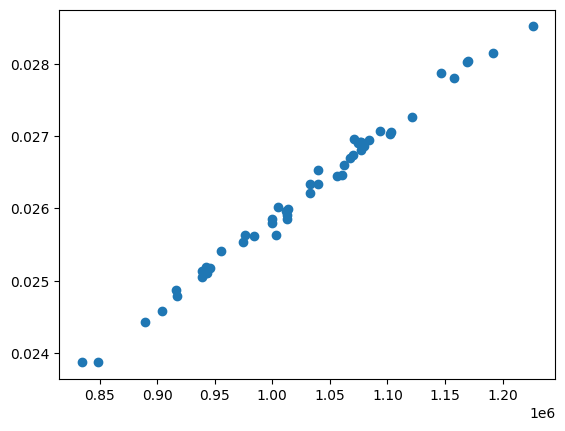

In [7]:
##### Generate data Y

#np.random.seed(0) # to keep it reproducible

# Size of dataset (number of turbines)
size = 5 # turbines
n = 10 # observations

# v2
# global params
GEk = [0]
GVk = [0.05]
# local params
LEk = np.random.lognormal(GEk, GVk, size=size) # 
LVk = [0.1] # attributed to changing stiffness of a foundation over time

# draw local turbine observations for each turbine
soil_k = np.zeros((n*size,1))
count = 0
for i in range(size):
    for j in range(n):
        soil_k[count] = np.random.lognormal(LEk[i] - 1, LVk) * 1000000
        count += 1

soil_k = np.squeeze(soil_k)

sigma = 0.0001 # natural frequency measurement error
Y = wtg_foundation(soil_model_switch=1, soil_k_vec=soil_k) + np.random.normal(loc=0, scale=sigma, size=n*size).reshape(-1,1) # add noise to the measured natural frequency
plt.scatter(soil_k, Y)

np.savetxt("GeneratedY.csv", Y, delimiter=",") # save 

In [10]:
np.savetxt("GeneratedY.csv", Y, delimiter=",") # save 

In [9]:
Z = np.genfromtxt('GeneratedY.csv', delimiter=',')

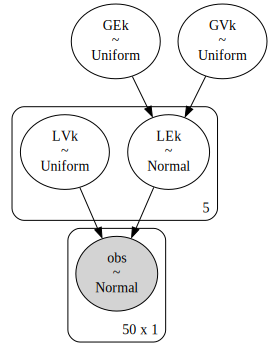

In [4]:
# Partially pooled aka hierarchical model

# Generated data priors
#Ek = N[1e+6, 1e+5] (of size number of turbines) # should be positive only (can't have negative stiffness)
# Vk ~ N[1e+5, 1e+4] (of size number of turbines) # should be positive only (can't have negative variance)
# k ~ N(Ek, Vk) (number of turbines x observations) # but should be positive only

# # vague priors for sampling
# Tk = pm.LogNormal('Ek0', 0, 0.5)
# Tki = pm.LogNormal('Tki', Tk, 0.5)
# for i in range(size):
#     soil_k[:,i] = pm.LogNormal(Tk[i] - 1, 0.5, size=n) * 1000000


# # hyperpriors

# mu_mu_soil_k = 1000000
# var_mu_soil_k = 100000

# mu_var_soil_k = 100000
# var_var_soil_k = 10000

# # draw soil distribution parameters for each turbine
# mu_soil_k = np.random.normal(loc=mu_mu_soil_k, scale=var_mu_soil_k, size=size) # turbines x 1
# var_soil_k = np.random.normal(loc=mu_var_soil_k, scale=var_var_soil_k, size=size) # turbines x 1



with pm.Model() as hierarchical_model:
    
    # globals
    GEk = pm.Uniform('GEk', 5e+5, 1.5e+6) # hyperprior 1
    GVk = pm.Uniform('GVk', 1e+4, 1e+5) # hyperprior 2
    
    # locals
    LEk = pm.Normal('LEk', GEk, GVk, shape=5) # draw stiffness expectation for each turbine
    LVk = pm.Uniform('LVk', 1e+3, 1e+4, shape=5) # draw stiffness variance for each turbine
    #noise = pm.Exponential('noise', 1)
    
    #sampled_k = pm.Normal('ki', LEk, LVk)
    #sigma = 0.0001
    obs = pm.Normal('obs', LEk, LVk, observed=Y) 
    #+ np.random.normal(loc=0, scale=sigma)
    
    #hierarchical_trace = pm.sample(
    #    return_inferencedata=True,
    #    target_accept=0.995
    #)

pm.model_to_graphviz(hierarchical_model)
#az.plot_posterior(hierarchical_trace)

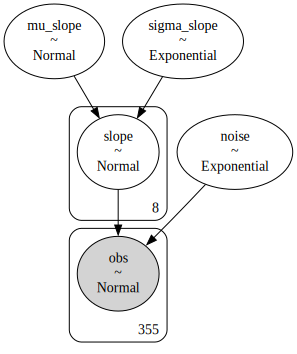

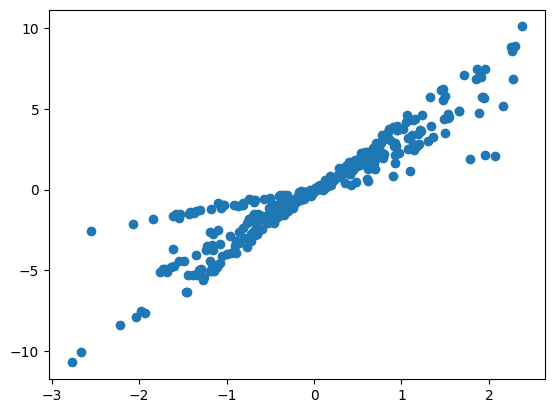

In [34]:
np.random.seed(0) # to keep it reproducible

mean_slope = 2 # the 8 different slopes have a mean of 2

slopes = np.random.normal(mean_slope, size=8)
groups = np.array(50*[0, 1, 2, 3, 4, 5, 6] + 5*[7])

x = np.random.randn(355)
y = slopes[groups] * x + 0.1*np.random.randn(355)
plt.scatter(x,y)

with pm.Model() as hierarchical_model:
    mu_slope = pm.Normal('mu_slope', 0, 1) # hyperprior 1
    sigma_slope = pm.Exponential('sigma_slope', 13) # hyperprior 2
    
    slope = pm.Normal('slope', mu_slope, sigma_slope, shape=8)
    noise = pm.Exponential('noise', 10)
    
    obs = pm.Normal('obs', slope[groups]*x, noise, observed=y)
    
    # hierarchical_trace = pm.sample(
    #     return_inferencedata=True,
    #     target_accept=0.995
    # )
pm.model_to_graphviz(hierarchical_model)
#az.plot_posterior(hierarchical_trace)

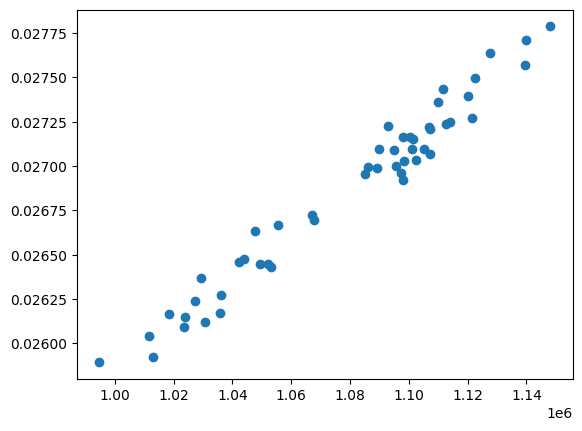

In [9]:
plt.scatter(soil_k, Y)

(array([439., 402., 330., 316., 290., 245., 244., 192., 215., 196., 191.,
        126., 160., 124., 123., 110.,  96.,  96.,  93.,  67.,  87.,  68.,
         64.,  59.,  53.,  49.,  40.,  52.,  43.,  42.,  30.,  27.,  27.,
         25.,  31.,  14.,  26.,  18.,  17.,  13.,   9.,   7.,  13.,   8.,
          9.,  11.,   8.,   9.,  12.,   5.,   7.,   7.,   7.,   2.,   2.,
          2.,   1.,   3.,   1.,   6.,   2.,   3.,   1.,   0.,   2.,   3.,
          5.,   0.,   2.,   0.,   2.,   0.,   2.,   0.,   0.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([2.30611904e-04, 8.86351437e-02, 1.77039676e-01, 2.65444207e-01,
        3.53848739e-01, 4.42253271e-01, 5.30657803e-01, 6.19062335e-01,
        7.07466866e-01, 7.95871398e-01, 8.84275930e-01, 9.72680462e-01,
        1.06108499e+00, 1.14948953e+00, 1.23789406e+00, 1.32629859e+00,
        1.41470312e+00, 1.5031

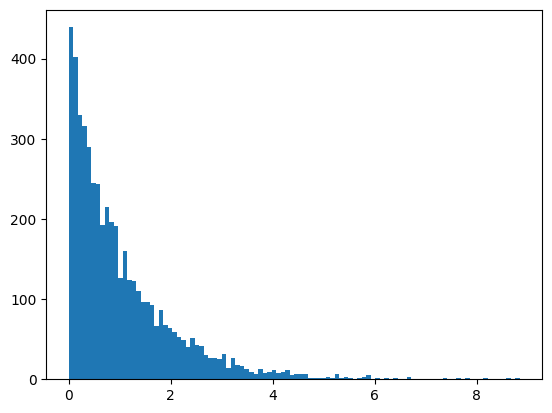

In [31]:
y = np.random.exponential(1, size=5000)
plt.hist(y, bins=100)
#plt.xlim(0,1)